In [1]:
import sklearn.datasets
from sklearn.cross_validation import train_test_split
import re
import tensorflow as tf
from sklearn import metrics
import numpy as np
import collections
import time
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def clearstring(string):
    string = re.sub('[^A-Za-z ]+', '', string)
    string = string.split('\n')
    string = [y.strip() for y in filter(None, string)]
    string = (' '.join(string)).lower()
    return ' '.join([y.strip() for y in string.split()])

def separate_dataset(trainset):
    datastring = []
    datatarget = []
    for i in range(len(trainset.data)):
        data_ = trainset.data[i].split('\n')
        data_ = list(filter(None, data_))
        for n in range(len(data_)):
            data_[n] = clearstring(data_[n])
        datastring += data_
        for n in range(len(data_)):
            datatarget.append(trainset.target[i])
    return datastring, datatarget

def build_dataset(words, n_words):
    count = [['GO', 0], ['PAD', 1], ['EOS', 2], ['UNK', 3]]
    count.extend(collections.Counter(words).most_common(n_words))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 0)
        if index == 0:
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

def str_idx(corpus, dic, maxlen, UNK=3):
    X = np.zeros((len(corpus),maxlen))
    for i in range(len(corpus)):
        for no, k in enumerate(corpus[i].split()[:maxlen][::-1]):
            try:
                X[i,-1 - no]=dic[k]
            except Exception as e:
                X[i,-1 - no]=UNK
    return X

In [3]:
dataset = sklearn.datasets.load_files(container_path = 'data', encoding = 'UTF-8')
dataset.data, dataset.target = separate_dataset(dataset)
_,dataset.data,_,dataset.target=train_test_split(dataset.data,dataset.target,test_size = 0.03)
len(dataset.data)

320

In [4]:
concat = ' '.join(dataset.data).split()
vocabulary_size = len(list(set(concat)))
data, count, dictionary, rev_dictionary = build_dataset(concat, vocabulary_size)
print('vocab from size: %d'%(vocabulary_size))
print('Most common words', count[4:10])
print('Sample data', data[:10], [rev_dictionary[i] for i in data[:10]])

vocab from size: 2392
Most common words [('the', 321), ('a', 212), ('and', 194), ('of', 177), ('to', 146), ('is', 100)]
Sample data [1632, 9, 17, 1947, 7, 887, 36, 7, 4, 121] ['eastwood', 'is', 'an', 'icon', 'of', 'moviemaking', 'one', 'of', 'the', 'best']


In [5]:
GO = dictionary['GO']
PAD = dictionary['PAD']
EOS = dictionary['EOS']
UNK = dictionary['UNK']

In [6]:
class Model:
    def __init__(self, size_layer, num_layers, embedded_size,
                 dict_size, dimension_output, learning_rate,seq_len):
        def cells(size,reuse=False):
            return tf.nn.rnn_cell.LSTMCell(size,initializer=tf.orthogonal_initializer(),reuse=reuse)
        self.X = tf.placeholder(tf.int32, [None, None])
        encoder_embeddings = tf.Variable(tf.random_uniform([dict_size, embedded_size], 0, 1))
        encoder_embedded = tf.nn.embedding_lookup(encoder_embeddings, self.X)
        rnn_cells = tf.nn.rnn_cell.MultiRNNCell([cells(size_layer) for _ in range(num_layers)])
        outputs, _ = tf.nn.dynamic_rnn(rnn_cells, encoder_embedded, dtype = tf.float32)
        outputs = tf.reshape(outputs,[-1,seq_len*size_layer])
        W = tf.get_variable('w',shape=(size_layer*seq_len, dimension_output),initializer=tf.orthogonal_initializer())
        b = tf.get_variable('b',shape=(dimension_output),initializer=tf.zeros_initializer())
        self.logits = tf.nn.tanh(tf.matmul(outputs, W) + b)
        W_decoder = tf.get_variable('w_decoder',shape=(dimension_output,size_layer*seq_len),initializer=tf.orthogonal_initializer())
        b_decoder = tf.get_variable('b_decoder',shape=(size_layer*seq_len),initializer=tf.zeros_initializer())
        logits_decoder = tf.nn.tanh(tf.matmul(self.logits,W_decoder) + b_decoder)
        logits_decoder = tf.reshape(logits_decoder,[-1,seq_len,size_layer])
        with tf.variable_scope("decoder"):
            rnn_cells_decoder = tf.nn.rnn_cell.MultiRNNCell([cells(embedded_size) for _ in range(num_layers)])
            outputs, _ = tf.nn.dynamic_rnn(rnn_cells_decoder, logits_decoder, dtype = tf.float32)
        decoder_dense = tf.layers.dense(outputs,dict_size)
        onehot_X = tf.one_hot(self.X,dict_size,axis=2,dtype=tf.float32)
        loss=tf.nn.softmax_cross_entropy_with_logits(labels = onehot_X, logits = decoder_dense)
        self.cost = tf.reduce_mean(loss)
        self.optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(self.cost)

In [7]:
size_layer = 256
num_layers = 2
embedded_size = 128
dimension_output = 100
learning_rate = 1e-2
maxlen = 50
batch_size = 32
epoch = 10

In [8]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(size_layer,num_layers,embedded_size,vocabulary_size+4,dimension_output,learning_rate,maxlen)
sess.run(tf.global_variables_initializer())

In [9]:
X = str_idx(dataset.data,dictionary,maxlen)
Y = dataset.target

In [10]:
for i in range(epoch):
    total_loss = 0
    for k in range(0, (X.shape[0]//batch_size)*batch_size,batch_size):
        loss,_ = sess.run([model.cost,model.optimizer],feed_dict={model.X:X[k:k+batch_size,:]})
        total_loss += loss
    total_loss /= (X.shape[0]//batch_size)
    print('epoch %d, avg loss %f'%(i+1,total_loss))

epoch 1, avg loss 7.760394
epoch 2, avg loss 7.704803
epoch 3, avg loss 7.635571
epoch 4, avg loss 7.540095
epoch 5, avg loss 7.259135
epoch 6, avg loss 5.018867
epoch 7, avg loss 4.009128
epoch 8, avg loss 3.605722
epoch 9, avg loss 3.323606
epoch 10, avg loss 3.199110


In [11]:
logits_test = sess.run(tf.nn.sigmoid(model.logits),feed_dict={model.X:X})
logits_test.shape

(320, 100)

In [15]:
logits_test

array([[0.7244937 , 0.71604526, 0.2728961 , ..., 0.7290659 , 0.6692666 ,
        0.7200828 ],
       [0.72441274, 0.7157007 , 0.27314687, ..., 0.7290498 , 0.66894525,
        0.72017443],
       [0.7248277 , 0.71632665, 0.27279508, ..., 0.7290951 , 0.6697026 ,
        0.720635  ],
       ...,
       [0.72442067, 0.71599936, 0.27315977, ..., 0.72899246, 0.6683353 ,
        0.72006834],
       [0.7250132 , 0.7173392 , 0.2725796 , ..., 0.7291803 , 0.6708015 ,
        0.72104675],
       [0.7243585 , 0.71537685, 0.27310753, ..., 0.728969  , 0.6686277 ,
        0.7199703 ]], dtype=float32)

In [12]:
from sklearn.manifold import TSNE
manifold_polarity = TSNE(n_components=2).fit_transform(logits_test)

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import offsetbox

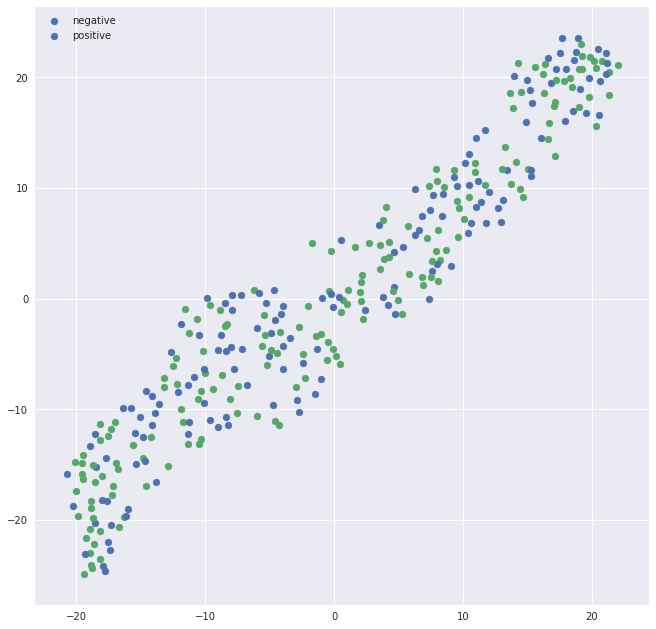

In [14]:
ax_min = np.min(logits_test,0)
ax_max = np.max(logits_test,0)
ax_dist_sq = np.sum((ax_max-ax_min)**2)
plt.figure(figsize=(11,11))
ax = plt.subplot(111)
shown_images = np.array([[1., 1.]])
colors = sns.color_palette(n_colors=len(dataset.target_names))
for i in range(manifold_polarity.shape[0]):
    dist = np.sum((manifold_polarity[i] - shown_images)**2, 1)
    if np.min(dist) < 3e-4*ax_dist_sq:
        continue
    shown_images = np.r_[shown_images, [manifold_polarity[i]]]
    plt.scatter(manifold_polarity[i,0],manifold_polarity[i,1],c=colors[Y[i]])
plt.legend(dataset.target_names)
plt.show()